In [32]:
!pip install matplotlib
!pip install numpy

In [18]:
import numpy as np
import matplotlib.pyplot as plt

path = "dsprites_ndarray_co1sh3sc6or40x32y32_64x64.npz"
data = np.load(path, allow_pickle=True, encoding="latin1")
imgs = data["imgs"]
latents_classes = data["latents_classes"]
metadata = data["metadata"][()]
latents_names = metadata["latents_names"]

print("✅ Dataset loaded successfully!")
print("Images shape:", imgs.shape)
print("Latent names:", latents_names)
print("Latent sizes:", metadata["latents_sizes"])



✅ Dataset loaded successfully!
Images shape: (737280, 64, 64)
Latent names: ('color', 'shape', 'scale', 'orientation', 'posX', 'posY')
Latent sizes: [ 1  3  6 40 32 32]


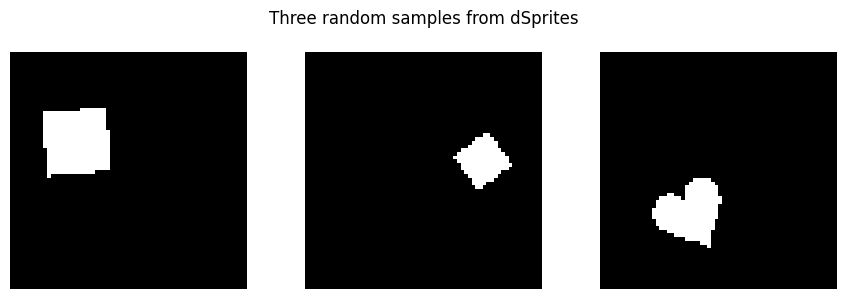

In [29]:
indices = np.random.choice(len(imgs), 3, replace=False)
samples = imgs[indices]

plt.figure(figsize=(9, 3))
for i, img in enumerate(samples):
    plt.subplot(1, 3, i + 1)
    plt.imshow(img, cmap="gray", interpolation="nearest")
    plt.axis("off")
    
plt.suptitle("Three random samples from dSprites", fontsize=12)
plt.tight_layout()
plt.show()


In [34]:
!pip install torch

🚀 Training new model...
Epoch 1/50  Total=325.4320  Recon=290.9125  KL=34.5195
Epoch 2/50  Total=124.5175  Recon=94.1020  KL=30.4154
Epoch 3/50  Total=87.0449  Recon=57.9978  KL=29.0471
Epoch 4/50  Total=75.4522  Recon=50.7551  KL=24.6971
Epoch 5/50  Total=69.2214  Recon=47.4450  KL=21.7764
Epoch 6/50  Total=65.5206  Recon=45.6054  KL=19.9152
Epoch 7/50  Total=63.2164  Recon=44.4463  KL=18.7700
Epoch 8/50  Total=61.6291  Recon=43.6465  KL=17.9826
Epoch 9/50  Total=60.4602  Recon=43.1334  KL=17.3267
Epoch 10/50  Total=59.7297  Recon=42.7473  KL=16.9824
Epoch 11/50  Total=58.9443  Recon=42.3986  KL=16.5457
Epoch 12/50  Total=58.3480  Recon=42.1436  KL=16.2044
Epoch 13/50  Total=57.6122  Recon=41.8175  KL=15.7947
Epoch 14/50  Total=57.2061  Recon=41.5391  KL=15.6670
Epoch 15/50  Total=56.6204  Recon=41.2787  KL=15.3418
Epoch 16/50  Total=56.4510  Recon=41.2697  KL=15.1813
Epoch 17/50  Total=55.8960  Recon=40.9277  KL=14.9682
Epoch 18/50  Total=55.5394  Recon=40.7558  KL=14.7836
Epoch 19/5

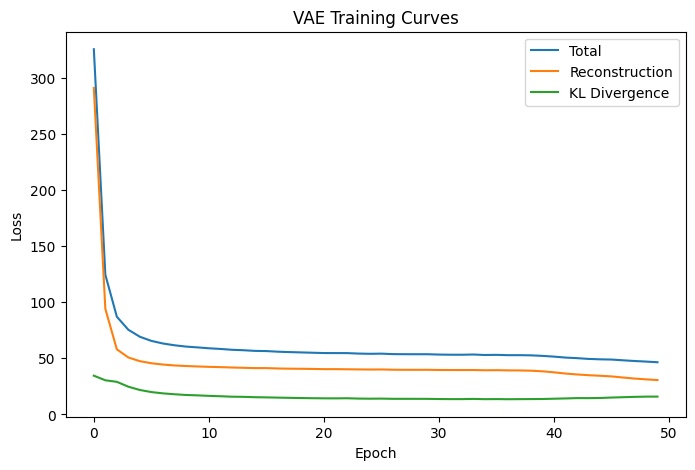

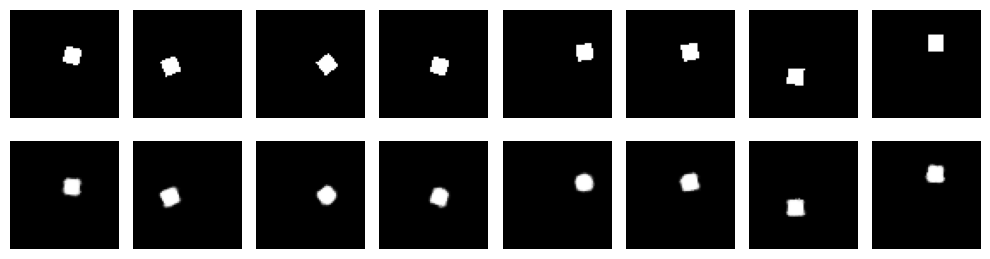

In [46]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
import os


path = "dsprites_ndarray_co1sh3sc6or40x32y32_64x64.npz"
data = np.load(path, allow_pickle=True, encoding="latin1")
imgs = data["imgs"].astype("float32")[:20000]
imgs = torch.tensor(imgs).unsqueeze(1)  # [N, 1, 64, 64]
train_loader = DataLoader(TensorDataset(imgs), batch_size=128, shuffle=True)


h_dim = 128
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 32, 4, 2, 1), nn.ReLU(),
            nn.Conv2d(32, 64, 4, 2, 1), nn.ReLU(),
            nn.Conv2d(64, 128, 4, 2, 1), nn.ReLU(),
            nn.Flatten()
        )
        self.fc_mu = nn.Linear(128 * 8 * 8, h_dim)
        self.fc_logvar = nn.Linear(128 * 8 * 8, h_dim)

    def forward(self, x):
        x = self.conv(x)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Linear(h_dim, 128 * 8 * 8)
        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 4, 2, 1), nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, 2, 1), nn.ReLU(),
            nn.ConvTranspose2d(32, 1, 4, 2, 1), nn.Sigmoid()
        )

    def forward(self, z):
        x = self.fc(z)
        x = x.view(-1, 128, 8, 8)
        x = self.deconv(x)
        return x

class VAE(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        recon_x = self.decoder(z)
        return recon_x, mu, logvar

def loss_function(recon_x, x, mu, logvar):
    recon_loss = nn.functional.binary_cross_entropy(recon_x, x, reduction="sum")
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl_loss, recon_loss, kl_loss


model_path = "vae_model_20k.pth"
model = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 50

train_losses, recon_losses, kl_losses = [], [], []

if os.path.exists(model_path):
    print("✅ Pretrained model found! Loading weights...")
    model.load_state_dict(torch.load(model_path))
else:
    print(" Training new model...")
    for epoch in range(epochs):
        total_loss, recon_total, kl_total = 0, 0, 0
        model.train()
        for (xb,) in train_loader:
            xb = xb.to(device)
            recon_x, mu, logvar = model(xb)
            loss, recon, kl = loss_function(recon_x, xb, mu, logvar)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            recon_total += recon.item()
            kl_total += kl.item()

        train_losses.append(total_loss/len(imgs))
        recon_losses.append(recon_total/len(imgs))
        kl_losses.append(kl_total/len(imgs))
        print(f"Epoch {epoch+1}/{epochs}  Total={train_losses[-1]:.4f}  Recon={recon_losses[-1]:.4f}  KL={kl_losses[-1]:.4f}")

    torch.save(model.state_dict(), model_path)
    print(" Model saved successfully!")


if train_losses:
    plt.figure(figsize=(8,5))
    plt.plot(train_losses, label="Total")
    plt.plot(recon_losses, label="Reconstruction")
    plt.plot(kl_losses, label="KL Divergence")
    plt.xlabel("Epoch"); plt.ylabel("Loss")
    plt.title("VAE Training Curves")
    plt.legend(); plt.show()


model.eval()
with torch.no_grad():
    x = next(iter(train_loader))[0][:8].to(device)
    recon, _, _ = model(x)

plt.figure(figsize=(10,3))
for i in range(8):
    plt.subplot(2,8,i+1)
    plt.imshow(x[i,0].cpu(), cmap="gray"); plt.axis("off")
    if i == 0: plt.ylabel("Original", fontsize=10)
    plt.subplot(2,8,i+9)
    plt.imshow(recon[i,0].cpu(), cmap="gray"); plt.axis("off")
    if i == 0: plt.ylabel("Reconstructed", fontsize=10)
plt.tight_layout(); plt.show()


[β=3.0] Epoch 1: Total=524.262
[β=3.0] Epoch 2: Total=197.715
[β=3.0] Epoch 3: Total=188.075
[β=3.0] Epoch 4: Total=172.381
[β=3.0] Epoch 5: Total=137.164
[β=3.0] Epoch 6: Total=124.221
[β=3.0] Epoch 7: Total=113.326
[β=3.0] Epoch 8: Total=104.489
[β=3.0] Epoch 9: Total=97.882
[β=3.0] Epoch 10: Total=92.938
[β=3.0] Epoch 11: Total=90.308
[β=3.0] Epoch 12: Total=88.103
[β=3.0] Epoch 13: Total=86.276
[β=3.0] Epoch 14: Total=84.373
[β=3.0] Epoch 15: Total=83.506
[β=3.0] Epoch 16: Total=82.894
[β=3.0] Epoch 17: Total=81.843
[β=3.0] Epoch 18: Total=81.531
[β=3.0] Epoch 19: Total=81.432
[β=3.0] Epoch 20: Total=80.584
[β=3.0] Epoch 21: Total=80.249
[β=3.0] Epoch 22: Total=80.101
[β=3.0] Epoch 23: Total=79.338
[β=3.0] Epoch 24: Total=79.054
[β=3.0] Epoch 25: Total=78.991
[β=10.0] Epoch 1: Total=719.143
[β=10.0] Epoch 2: Total=287.529
[β=10.0] Epoch 3: Total=250.729
[β=10.0] Epoch 4: Total=235.900
[β=10.0] Epoch 5: Total=226.835
[β=10.0] Epoch 6: Total=220.514
[β=10.0] Epoch 7: Total=211.491
[β

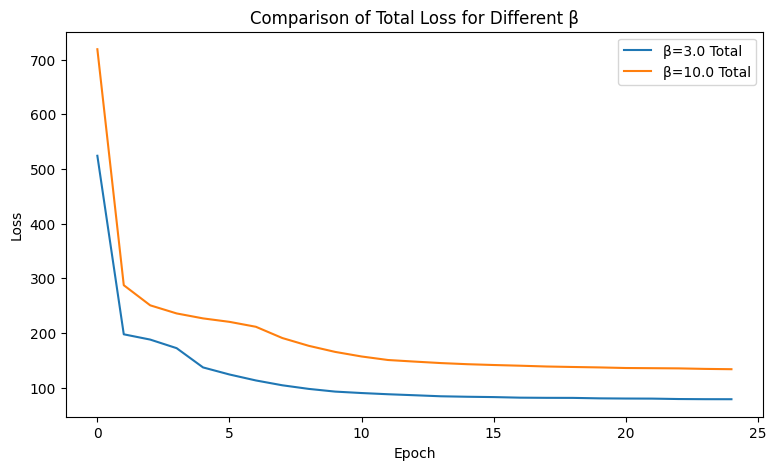

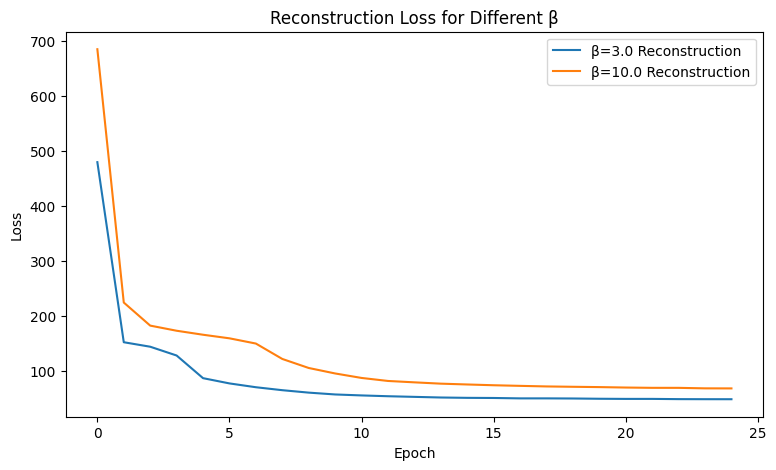

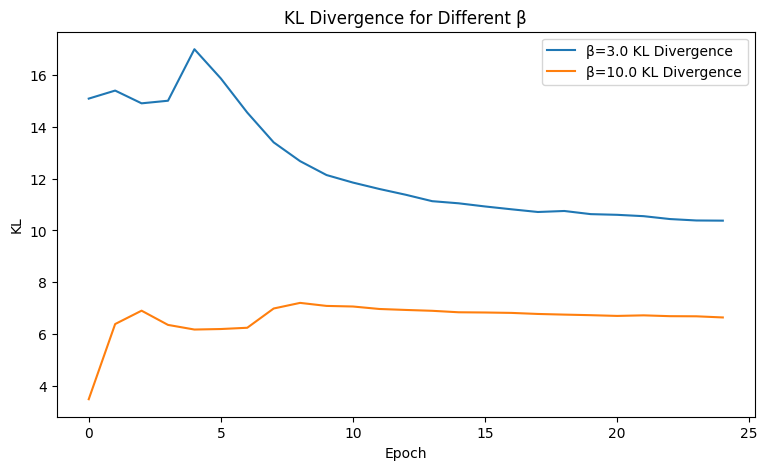

RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

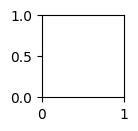

In [47]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt

# -----------------------------
# Load dataset
# -----------------------------
path = "dsprites_ndarray_co1sh3sc6or40x32y32_64x64.npz"
data = np.load(path, allow_pickle=True, encoding="latin1")
imgs = data["imgs"].astype("float32")[:10000]
imgs = torch.tensor(imgs).unsqueeze(1)
loader = DataLoader(TensorDataset(imgs), batch_size=128, shuffle=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
h_dim = 128

class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 32, 4, 2, 1), nn.ReLU(),
            nn.Conv2d(32, 64, 4, 2, 1), nn.ReLU(),
            nn.Conv2d(64, 128, 4, 2, 1), nn.ReLU(),
            nn.Flatten()
        )
        self.fc_mu = nn.Linear(128 * 8 * 8, h_dim)
        self.fc_logvar = nn.Linear(128 * 8 * 8, h_dim)

    def forward(self, x):
        x = self.conv(x)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Linear(h_dim, 128 * 8 * 8)
        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 4, 2, 1), nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, 2, 1), nn.ReLU(),
            nn.ConvTranspose2d(32, 1, 4, 2, 1), nn.Sigmoid()
        )

    def forward(self, z):
        z = self.fc(z)
        z = z.view(-1, 128, 8, 8)
        return self.deconv(z)

class BetaVAE(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        recon = self.decoder(z)
        return recon, mu, logvar

def loss_fn(recon_x, x, mu, logvar, beta=1.0):
    recon_loss = nn.functional.binary_cross_entropy(recon_x, x, reduction="sum")
    kl = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + beta * kl, recon_loss, kl


def train_beta_vae(beta, epochs=20):
    model = BetaVAE().to(device)
    opt = optim.Adam(model.parameters(), lr=0.001)
    total_hist, rec_hist, kl_hist = [], [], []
    for epoch in range(epochs):
        total, rec, kl = 0, 0, 0
        for (xb,) in loader:
            xb = xb.to(device)
            recon, mu, logvar = model(xb)
            loss, r, k = loss_fn(recon, xb, mu, logvar, beta)
            opt.zero_grad()
            loss.backward()
            opt.step()
            total += loss.item()
            rec += r.item()
            kl += k.item()
        total_hist.append(total/len(imgs))
        rec_hist.append(rec/len(imgs))
        kl_hist.append(kl/len(imgs))
        print(f"[β={beta}] Epoch {epoch+1}: Total={total_hist[-1]:.3f}")
    return model, total_hist, rec_hist, kl_hist


betas = [3.0, 10.0]
histories = {}
epochs = 25

for b in betas:
    model, total, rec, kl = train_beta_vae(b, epochs=epochs)
    histories[b] = {"model": model, "total": total, "recon": rec, "kl": kl}

plt.figure(figsize=(9,5))
for b in betas:
    plt.plot(histories[b]["total"], label=f"β={b} Total")
plt.title("Comparison of Total Loss for Different β")
plt.xlabel("Epoch"); plt.ylabel("Loss")
plt.legend(); plt.show()

plt.figure(figsize=(9,5))
for b in betas:
    plt.plot(histories[b]["recon"], label=f"β={b} Reconstruction")
plt.title("Reconstruction Loss for Different β")
plt.xlabel("Epoch"); plt.ylabel("Loss")
plt.legend(); plt.show()

plt.figure(figsize=(9,5))
for b in betas:
    plt.plot(histories[b]["kl"], label=f"β={b} KL Divergence")
plt.title("KL Divergence for Different β")
plt.xlabel("Epoch"); plt.ylabel("KL")
plt.legend(); plt.show()




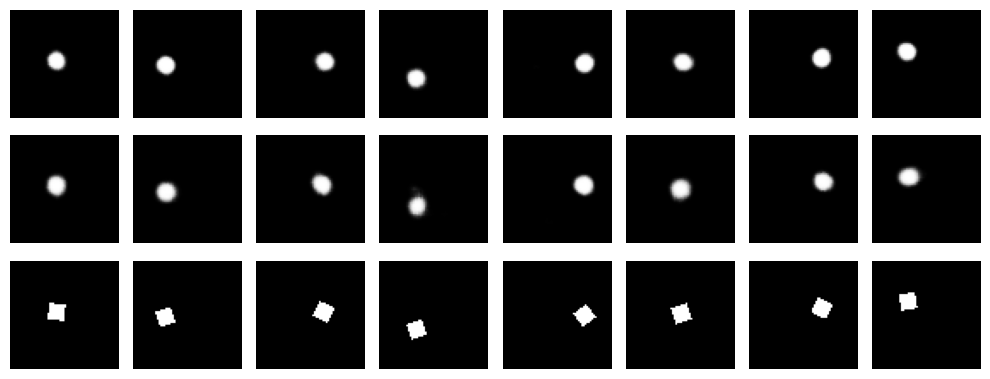

In [48]:
with torch.no_grad():
    x = next(iter(loader))[0][:8].to(device)

plt.figure(figsize=(10,4))
for i, b in enumerate(betas):
    model = histories[b]["model"]
    model.eval()
    recon, _, _ = model(x)
    for j in range(8):
        plt.subplot(len(betas)+1,8,i*8 + j + 1)
        plt.imshow(recon[j,0].detach().cpu().numpy(), cmap="gray")  # ← اینجا اصلاح شد
        plt.axis("off")
        if j == 0:
            plt.ylabel(f"β={b}", fontsize=9)

# Original images row
for j in range(8):
    plt.subplot(len(betas)+1,8,len(betas)*8 + j + 1)
    plt.imshow(x[j,0].detach().cpu().numpy(), cmap="gray")  # ← اینم بهتره با detach
    plt.axis("off")
    if j == 0:
        plt.ylabel("Original", fontsize=9)

plt.tight_layout()
plt.show()


In [50]:
!pip install scipy


   ---------------------------------------- 0.0/39.4 MB ? eta -:--:--
   ---------------------------------------- 0.0/39.4 MB ? eta -:--:--
    --------------------------------------- 0.5/39.4 MB 2.2 MB/s eta 0:00:18
   -- ------------------------------------- 2.1/39.4 MB 5.4 MB/s eta 0:00:07
   --- ------------------------------------ 3.7/39.4 MB 6.3 MB/s eta 0:00:06
   ----- ---------------------------------- 5.8/39.4 MB 7.2 MB/s eta 0:00:05
   ------- -------------------------------- 7.1/39.4 MB 7.0 MB/s eta 0:00:05
   --------- ------------------------------ 8.9/39.4 MB 7.3 MB/s eta 0:00:05
   ---------- ----------------------------- 10.7/39.4 MB 7.5 MB/s eta 0:00:04
   ------------ --------------------------- 12.3/39.4 MB 7.6 MB/s eta 0:00:04
   -------------- ------------------------- 14.2/39.4 MB 7.7 MB/s eta 0:00:04
   ---------------- ----------------------- 16.0/39.4 MB 7.8 MB/s eta 0:00:04
   ------------------ --------------------- 17.8/39.4 MB 7.9 MB/s eta 0:00:03
   -----

In [64]:
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset, Subset
from scipy.stats import entropy

def get_latents_means(model, loader, device):
 
    model.eval()
    all_mu = []
    with torch.no_grad():
        for (xb,) in loader:
            xb = xb.to(device)
            mu, _ = model.encoder(xb)
            all_mu.append(mu.cpu().numpy())
    return np.concatenate(all_mu, axis=0)  # [N, z_dim]


def quantile_digitize(x, bins=20):
   
    qs = np.linspace(0, 1, bins + 1)
    edges = np.quantile(x, qs)
    edges[0], edges[-1] = -np.inf, np.inf
    return np.digitize(x, edges[1:-1])  # برچسب‌ها از 0 تا bins-1


def mutual_info_discrete(x_disc, y_disc, nx=None, ny=None, eps=1e-12):
  
    if nx is None:
        nx = int(x_disc.max()) + 1
    if ny is None:
        ny = int(y_disc.max()) + 1
    joint = np.zeros((nx, ny), dtype=np.float64)
    for a, b in zip(x_disc, y_disc):
        joint[int(a), int(b)] += 1
    joint /= joint.sum()
    px = joint.sum(axis=1, keepdims=True)
    py = joint.sum(axis=0, keepdims=True)
    nz = joint > 0
    mi = np.sum(joint[nz] * (np.log(joint[nz] + eps) - np.log(px.repeat(ny, axis=1)[nz] + eps)
                              - np.log(py.repeat(nx, axis=0)[nz] + eps)))
    return float(mi)


def compute_MIG(model, imgs_tensor, latents_classes, metadata, device,
                max_samples=20000, bins=20, batch_size=256, seed=0):


    rng = np.random.default_rng(seed)
    N_all = latents_classes.shape[0]
    N = min(max_samples, N_all)
    sel = rng.choice(N_all, size=N, replace=False)

    sub_loader = DataLoader(Subset(TensorDataset(imgs_tensor), sel),
                            batch_size=batch_size, shuffle=False)


    Z = get_latents_means(model, sub_loader, device)  # [N, z_dim]
    Z_disc = np.zeros_like(Z, dtype=np.int32)
    
    for j in range(Z.shape[1]):
        Z_disc[:, j] = quantile_digitize(Z[:, j], bins=bins)

    sizes = metadata["latents_sizes"]
    names = list(metadata["latents_names"])
    factor_ids = [i for i, n in enumerate(names) if n != "color"]

    migs, per_factor = [], {}

    for k in factor_ids:
        y = latents_classes[sel, k].astype(np.int64)
        ny = int(sizes[k])
        I = np.array([mutual_info_discrete(Z_disc[:, j], y, nx=bins, ny=ny)
                      for j in range(Z_disc.shape[1])])
        if len(I) < 2:
            continue
        top2 = np.partition(I, -2)[-2:]
        I1, I2 = np.sort(top2)[::-1]  

        p = np.bincount(y, minlength=ny).astype(np.float64)
        p /= p.sum()
        H = entropy(p)
        mig_k = (I1 - I2) / H if H > 0 else 0.0
        migs.append(mig_k)
        per_factor[names[k]] = mig_k

    MIG = float(np.mean(migs)) if migs else 0.0
    return MIG, per_factor



latents_classes_subset = data["latents_classes"][:len(imgs)]
MIG, per_factor = compute_MIG(
    model,
    imgs,
    latents_classes_subset,     
    data["metadata"][()],
    device,
    max_samples=10000,
    bins=20
)
print(" MIG =", round(MIG, 4))
print("Per-factor:", {k: round(v, 4) for k, v in per_factor.items()})



 MIG = 0.016
Per-factor: {'shape': 0.0, 'scale': 0.0, 'orientation': np.float64(0.0001), 'posX': np.float64(0.0392), 'posY': np.float64(0.0409)}


In [78]:
!pip install scikit-learn

   ---------------------------------------- 0.0/8.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/8.8 MB ? eta -:--:--
   - -------------------------------------- 0.3/8.8 MB ? eta -:--:--
   -------- ------------------------------- 1.8/8.8 MB 5.7 MB/s eta 0:00:02
   ----------------- ---------------------- 3.9/8.8 MB 7.8 MB/s eta 0:00:01
   ---------------------------- ----------- 6.3/8.8 MB 8.8 MB/s eta 0:00:01
   ---------------------------------------  8.7/8.8 MB 9.5 MB/s eta 0:00:01
   ---------------------------------------  8.7/8.8 MB 9.5 MB/s eta 0:00:01
   ---------------------------------------  8.7/8.8 MB 9.5 MB/s eta 0:00:01
   ---------------------------------------  8.7/8.8 MB 9.5 MB/s eta 0:00:01
   ---------------------------------------  8.7/8.8 MB 9.5 MB/s eta 0:00:01
   ---------------------------------------  8.7/8.8 MB 9.5 MB/s eta 0:00:01
   ---------------------------------------  8.7/8.8 MB 9.5 MB/s eta 0:00:01
   ------------------------------

β=1 | epoch 1/25 | loss=364.40
β=1 | epoch 2/25 | loss=133.52
β=1 | epoch 3/25 | loss=87.77
β=1 | epoch 4/25 | loss=77.19
β=1 | epoch 5/25 | loss=70.47
β=1 | epoch 6/25 | loss=66.92
β=1 | epoch 7/25 | loss=64.72
β=1 | epoch 8/25 | loss=62.98
β=1 | epoch 9/25 | loss=61.77
β=1 | epoch 10/25 | loss=60.93
β=1 | epoch 11/25 | loss=59.96
β=1 | epoch 12/25 | loss=59.35
β=1 | epoch 13/25 | loss=58.78
β=1 | epoch 14/25 | loss=58.33
β=1 | epoch 15/25 | loss=57.75
β=1 | epoch 16/25 | loss=57.38
β=1 | epoch 17/25 | loss=56.81
β=1 | epoch 18/25 | loss=56.62
β=1 | epoch 19/25 | loss=56.46
β=1 | epoch 20/25 | loss=56.14
β=1 | epoch 21/25 | loss=55.98
β=1 | epoch 22/25 | loss=55.49
β=1 | epoch 23/25 | loss=55.19
β=1 | epoch 24/25 | loss=55.24
β=1 | epoch 25/25 | loss=54.72
β=3 | epoch 1/25 | loss=458.94
β=3 | epoch 2/25 | loss=168.74
β=3 | epoch 3/25 | loss=128.55
β=3 | epoch 4/25 | loss=104.92
β=3 | epoch 5/25 | loss=95.19
β=3 | epoch 6/25 | loss=89.38
β=3 | epoch 7/25 | loss=86.67
β=3 | epoch 8/25 |

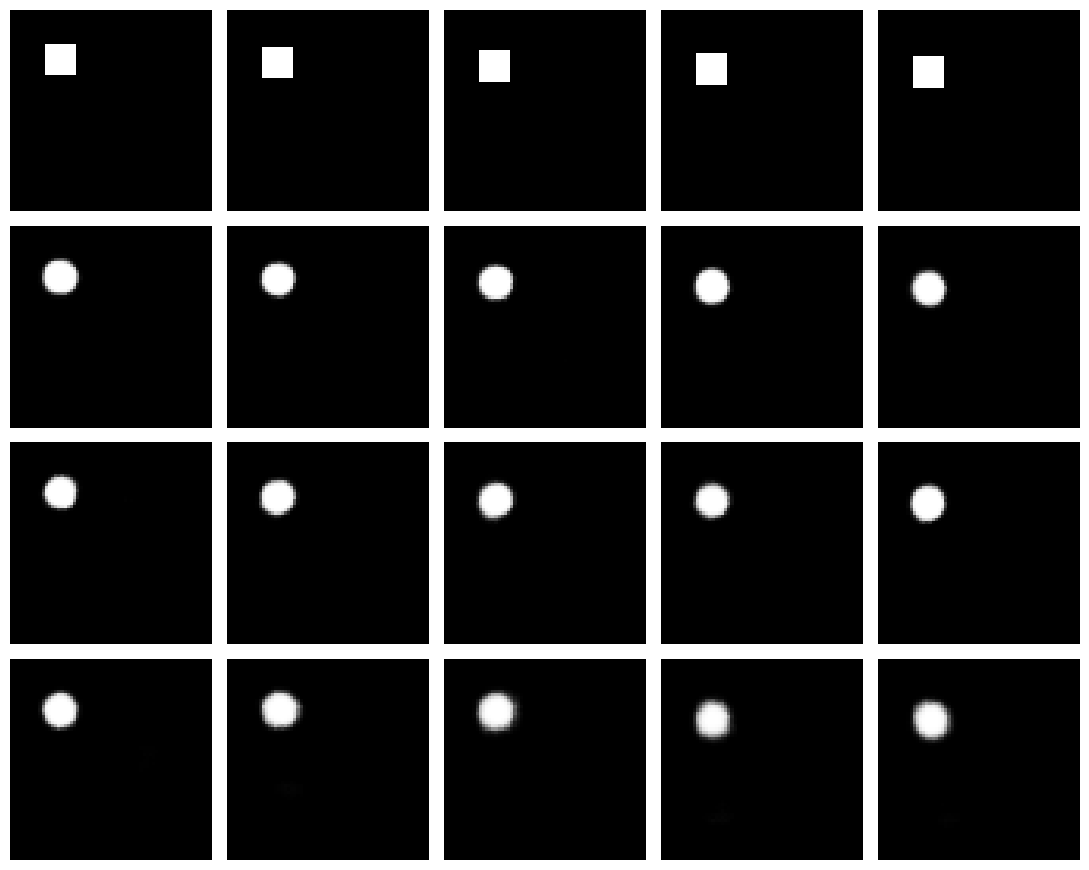

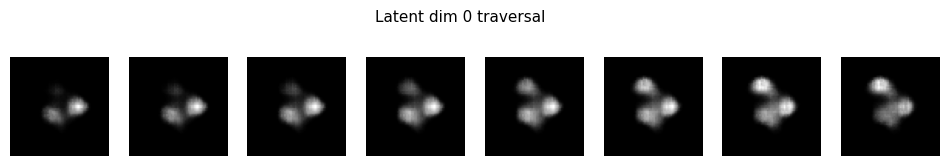

In [79]:
import torch, torch.nn as nn, torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Subset
import numpy as np, matplotlib.pyplot as plt, os
from sklearn.metrics import mutual_info_score
from scipy.stats import entropy

#this is just for the test, not working correctly

data = np.load(path, allow_pickle=True, encoding="latin1")
imgs = torch.tensor(data["imgs"].astype("float32")[:15000]).unsqueeze(1)
latents = data["latents_classes"][:len(imgs)]
meta = data["metadata"][()]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

h_dim = 64
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 32, 4, 2, 1), nn.ReLU(),
            nn.Conv2d(32, 64, 4, 2, 1), nn.ReLU(),
            nn.Conv2d(64, 128, 4, 2, 1), nn.ReLU(),
            nn.Flatten()
        )
        self.fc_mu = nn.Linear(128*8*8, h_dim)
        self.fc_logvar = nn.Linear(128*8*8, h_dim)
    def forward(self, x):
        x = self.conv(x)
        return self.fc_mu(x), self.fc_logvar(x)

class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Linear(h_dim, 128*8*8)
        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 4, 2, 1), nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, 2, 1), nn.ReLU(),
            nn.ConvTranspose2d(32, 1, 4, 2, 1), nn.Sigmoid()
        )
    def forward(self, z):
        z = self.fc(z).view(-1,128,8,8)
        return self.deconv(z)

class BetaVAE(nn.Module):
    def __init__(self): 
        super().__init__()
        self.encoder, self.decoder = Encoder(), Decoder()
    def reparam(self, mu, logv):
        std = torch.exp(0.5*logv); eps = torch.randn_like(std)
        return mu + eps*std
    def forward(self, x):
        mu, logv = self.encoder(x)
        z = self.reparam(mu, logv)
        return self.decoder(z), mu, logv

def loss_fn(recon,x,mu,logv,beta):
    rec = nn.functional.binary_cross_entropy(recon,x,reduction="sum")
    kl = -0.5*torch.sum(1+logv-mu.pow(2)-logv.exp())
    return rec + beta*kl

def train_beta(beta, epochs=20, subset=10000):
    model = BetaVAE().to(device)
    opt = optim.Adam(model.parameters(), lr=1e-3)
    loader = DataLoader(Subset(TensorDataset(imgs), range(subset)), batch_size=64, shuffle=True)
    for ep in range(epochs):
        total=0; model.train()
        for (xb,) in loader:
            xb=xb.to(device)
            recon,mu,logv=model(xb)
            loss=loss_fn(recon,xb,mu,logv,beta)
            opt.zero_grad(); loss.backward(); opt.step()
            total+=loss.item()
        print(f"β={beta} | epoch {ep+1}/{epochs} | loss={total/subset:.2f}")
    torch.save(model.state_dict(), f"vae_beta{int(beta)}.pth")
    return model

def load_or_train(beta):
    fn=f"vae_beta{int(beta)}.pth"
    if os.path.exists(fn):
        m=BetaVAE().to(device); m.load_state_dict(torch.load(fn,map_location=device)); m.eval()
        print(f"Loaded β={beta}")
        return m
    else:
        return train_beta(beta,epochs=25,subset=10000)

model_b1  = load_or_train(1)
model_b3  = load_or_train(3)
model_b10 = load_or_train(10)


def get_mu(model, imgs_tensor, N, device):
    loader = DataLoader(Subset(TensorDataset(imgs_tensor), range(N)), batch_size=128, shuffle=False)
    model.eval(); out=[]
    with torch.no_grad():
        for (xb,) in loader:
            xb=xb.to(device)
            mu,_=model.encoder(xb)
            out.append(mu.cpu().numpy())
    return np.concatenate(out,0)

def digitize_quantile(x,bins=20):
    qs=np.linspace(0,1,bins+1)
    edges=np.quantile(x,qs)
    edges[0],edges[-1]=-np.inf,np.inf
    return np.digitize(x,edges[1:-1])

def compute_MIG(model,imgs,latents,meta,device,bins=20,maxN=5000):
    N=min(maxN,len(imgs))
    Z=get_mu(model,imgs,N,device)
    Z=(Z-Z.mean(0))/(Z.std(0)+1e-8)
    Z_disc=np.stack([digitize_quantile(Z[:,j],bins) for j in range(Z.shape[1])],1)
    sizes=meta["latents_sizes"]; names=list(meta["latents_names"])
    factors=[i for i,n in enumerate(names) if n!="color"]
    migs=[]; per={}
    for k in factors:
        y=latents[:N,k].astype(int)
        y=(y-np.min(y)).astype(int)
        I=[mutual_info_score(Z_disc[:,j],y) for j in range(Z_disc.shape[1])]
        if len(I)<2: continue
        I1,I2=np.sort(I)[-2:]
        p=np.bincount(y).astype(float); p/=p.sum()
        H=entropy(p)
        m=(I1-I2)/H if H>0 else 0
        migs.append(m); per[names[k]]=m
    return float(np.mean(migs)),per

MIG1, per1   = compute_MIG(model_b1,  imgs, latents, meta, device)
MIG3, per3   = compute_MIG(model_b3,  imgs, latents, meta, device)
MIG10, per10 = compute_MIG(model_b10, imgs, latents, meta, device)

print(f"β=1   MIG={MIG1:.4f}  { {k:round(v,4) for k,v in per1.items()} }")
print(f"β=3   MIG={MIG3:.4f}  { {k:round(v,4) for k,v in per3.items()} }")
print(f"β=10  MIG={MIG10:.4f} { {k:round(v,4) for k,v in per10.items()} }")



def reconstruct_compare(models, imgs_tensor, device, n=5):
    x = imgs_tensor[:n].to(device)
    fig, axes = plt.subplots(len(models)+1, n, figsize=(n*2.2, (len(models)+1)*2.2))
    with torch.no_grad():
        for j, (name, model) in enumerate(models.items()):
            model.eval()
            recon, _, _ = model(x)
            for i in range(n):
                axes[j+1, i].imshow(recon[i,0].cpu(), cmap='gray')
                axes[j+1, i].axis("off")
                if i == 0: axes[j+1, i].set_ylabel(f"β={name}", fontsize=10)
    for i in range(n):
        axes[0, i].imshow(x[i,0].cpu(), cmap='gray')
        axes[0, i].axis("off")
        if i == 0: axes[0, i].set_ylabel("Input", fontsize=10)
    plt.tight_layout(); plt.show()

def latent_traversal(model, device, dim=0, steps=8):
    model.eval()
    z = torch.zeros((steps, h_dim)).to(device)
    values = torch.linspace(-3, 3, steps)
    for i, v in enumerate(values): z[i, dim] = v
    with torch.no_grad(): imgs_gen = model.decoder(z).cpu()
    fig, axes = plt.subplots(1, steps, figsize=(steps*1.5, 2))
    for i in range(steps):
        axes[i].imshow(imgs_gen[i,0], cmap='gray'); axes[i].axis("off")
    plt.suptitle(f"Latent dim {dim} traversal", fontsize=11)
    plt.show()

models = {"1": model_b1, "3": model_b3, "10": model_b10}
reconstruct_compare(models, imgs, device)
latent_traversal(model_b10, device, dim=0)


In [81]:
import numpy as np
from sklearn.metrics import mutual_info_score
from scipy.stats import entropy
import torch
from torch.utils.data import DataLoader, TensorDataset, Subset

def get_mu(model, imgs_tensor, N, device):
    loader = DataLoader(Subset(TensorDataset(imgs_tensor), range(N)), batch_size=128, shuffle=False)
    model.eval()
    mus = []
    with torch.no_grad():
        for (xb,) in loader:
            xb = xb.to(device)
            mu, _ = model.encoder(xb)
            mus.append(mu.cpu().numpy())
    return np.concatenate(mus, axis=0)

def digitize_quantile(x, bins=20):
    qs = np.linspace(0, 1, bins + 1)
    edges = np.quantile(x, qs)
    edges[0], edges[-1] = -np.inf, np.inf
    return np.digitize(x, edges[1:-1])

def compute_MIG(model, imgs, latents, meta, device, bins=20, maxN=5000):

    N = min(maxN, len(imgs))
    Z = get_mu(model, imgs, N, device)
    Z = (Z - Z.mean(0)) / (Z.std(0) + 1e-8)
    Z_disc = np.stack([digitize_quantile(Z[:, j], bins) for j in range(Z.shape[1])], 1)

    sizes = meta["latents_sizes"]
    names = list(meta["latents_names"])
    factors = [i for i, n in enumerate(names) if n != "color"]

    migs, per = [], {}

    for k in factors:
        y = latents[:N, k].astype(int)
        y = (y - np.min(y)).astype(int)
        I = [mutual_info_score(Z_disc[:, j], y) for j in range(Z_disc.shape[1])]
        if len(I) < 2:
            continue
      
        top2 = np.partition(I, -2)[-2:]
        Imax, Isecond = top2.max(), top2.min()

        p = np.bincount(y).astype(float)
        p /= p.sum()
        H = entropy(p)
        m = (Imax - Isecond) / H if H > 0 else 0.0

        migs.append(m)
        per[names[k]] = m

    return float(np.mean(migs)), per


In [82]:
MIG1, per1   = compute_MIG(model_b1,  imgs, latents, meta, device)
MIG3, per3   = compute_MIG(model_b3,  imgs, latents, meta, device)
MIG10, per10 = compute_MIG(model_b10, imgs, latents, meta, device)

print(f"β=1   MIG={MIG1:.4f}  { {k:round(v,4) for k,v in per1.items()} }")
print(f"β=3   MIG={MIG3:.4f}  { {k:round(v,4) for k,v in per3.items()} }")
print(f"β=10  MIG={MIG10:.4f} { {k:round(v,4) for k,v in per10.items()} }")


β=1   MIG=0.0108  {'shape': 0.0, 'scale': 0.0, 'orientation': np.float64(0.0013), 'posX': np.float64(0.0195), 'posY': np.float64(0.0331)}
β=3   MIG=0.0198  {'shape': 0.0, 'scale': 0.0, 'orientation': np.float64(0.001), 'posX': np.float64(0.0502), 'posY': np.float64(0.048)}
β=10  MIG=0.0138 {'shape': 0.0, 'scale': 0.0, 'orientation': np.float64(0.0), 'posX': np.float64(0.0492), 'posY': np.float64(0.0196)}
